# Installs and Imports

Disclaimer: You should create a virtual environment using the provided environment.yml and activate it before running the codes below

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Spring-Mass-Damper System Class

In [2]:
class SMDSystem:
    def __init__(self, A, B, C, noise_params):
        """
        Initialize the SMD system with:
          - System matrices A, B, C.
          - Noise parameters (process noise V, sensor noise W).
        """
        self.A = A  # state-transition matrix
        self.B = B  # control input matrix
        self.C = C  # observation matrix
        self.V = noise_params['V']  # process noise covariance
        self.W = noise_params['W']  # observation noise covariance
        
    def step(self, x, u):
        """
        Given the current state x and control input u, compute:
          - Next state: x_next = A*x + B*u + process_noise.
          - Observation: y = C*x_next + sensor_noise.
          
        Parameters:
            x : ndarray, shape (m,)
                Current state vector.
            u : ndarray, shape (k,)
                Control input vector.
        
        Returns:
            x_next : ndarray, shape (m,)
                Next state vector.
            y : ndarray, shape (n,)
                Observation vector.
        """
        m = self.A.shape[0]
        n = self.C.shape[0]
        
        # Process noise: sample from N(0, V)
        process_noise = np.random.multivariate_normal(np.zeros(m), self.V)
        
        # Compute next state: x_next = A*x + B*u + process_noise
        x_next = self.A.dot(x) + self.B.dot(u) + process_noise
        
        # Sensor noise: sample from N(0, W)
        sensor_noise = np.random.multivariate_normal(np.zeros(n), self.W)
        
        # Compute observation: y = C*x_next + sensor_noise
        y = self.C.dot(x_next) + sensor_noise
        
        return x_next, y

# Define the Spiking Neural Estimator Class (SCN)

In [3]:
class SpikingNeuralEstimator:
    def __init__(self, num_neurons, state_dim, params):
        """
        Initialize the SCN with:
          - Number of neurons (N).
          - State dimension (for position and velocity).
          - Parameters including:
              - Decoding matrix D.
              - Fast recurrent connectivity (Omega_f).
              - Slow recurrent connectivity (Omega_s).
              - Leak rate (lambda), threshold, and time step dt.
        
        Parameters:
            num_neurons: int
                Number of spiking neurons (N).
            state_dim: int
                Dimension of the state (e.g., 2 for [position, velocity]).
            params: dict
                Should contain:
                  - 'D_init': initial decoding matrix (or None to initialize randomly)
                  - 'leak_rate': leak rate (lambda)
                  - 'threshold': spike threshold
                  - 'dt': time step (default 1)
        """
        self.N = num_neurons
        self.state_dim = state_dim
        self.dt = params.get('dt', 1.0)
        self.leak_rate = params.get('leak_rate', 0.1)
        self.threshold = params.get('threshold', 1.0)
        
        # Initialize decoding matrix D: shape (state_dim, num_neurons)
        # If provided, use it; otherwise, initialize with random values and normalize each column.
        if params.get('D_init') is not None:
            self.D = params['D_init']
        else:
            self.D = np.random.randn(state_dim, num_neurons)
            # Normalize each column to unit norm
            self.D /= np.linalg.norm(self.D, axis=0, keepdims=True)
        
        # Compute fast recurrent connectivity Omega_f as -D^T * D
        self.Omega_f = -self.D.T.dot(self.D)
        
        # For slow recurrent connectivity, if needed, we set it to zero for now.
        self.Omega_s = np.zeros_like(self.Omega_f)
        
    def update_neurons(self, v, net_input):
        """
        Update the membrane potentials v based on:
          - Leak: -leak_rate * v.
          - Net input: provided externally (this can include feedforward input,
            plus contributions from recurrent connections computed elsewhere).
        Check for threshold crossings to produce spikes.
        
        Parameters:
            v: ndarray, shape (N,)
                Current membrane potentials.
            net_input: ndarray, shape (N,)
                Total input current to each neuron.
        
        Returns:
            s: ndarray, shape (N,)
                Binary spike vector (1 if neuron spikes, 0 otherwise).
            v_new: ndarray, shape (N,)
                Updated membrane potentials (reset for neurons that spiked).
        """
        # Update the membrane potential using Euler integration
        # v_new = v + dt * ( -leak_rate * v + net_input )
        v_new = v + self.dt * (-self.leak_rate * v + net_input)
        
        # Determine spikes: a neuron fires if its membrane potential crosses the threshold.
        s = (v_new >= self.threshold).astype(float)
        
        # Reset the membrane potential for spiking neurons (here, we reset to 0)
        v_new = v_new * (1 - s)
        
        return s, v_new

    def update_filtered_spikes(self, r, s):
        """
        Update the filtered spike train r using an exponential decay:
            r_new = r + dt * (-leak_rate * r + s)
        
        Parameters:
            r: ndarray, shape (N,)
                Current filtered spike train.
            s: ndarray, shape (N,)
                Current spike vector.
        
        Returns:
            r_new: ndarray, shape (N,)
                Updated filtered spike train.
        """
        r_new = r + self.dt * (-self.leak_rate * r + s)
        return r_new

    def decode_state(self, r):
        """
        Decode the current state estimate from the filtered spike train:
            x_hat = D * r
        
        Parameters:
            r: ndarray, shape (N,)
                Filtered spike train.
        
        Returns:
            x_hat: ndarray, shape (state_dim,)
                Decoded state estimate.
        """
        x_hat = self.D.dot(r)
        return x_hat

# Define the Spiking Controller Class

In [4]:
class SpikingController:
    def __init__(self, control_dim, num_neurons, learning_rate, sigma=0.1):
        """
        Initialize the controller that produces the control signal u.
          - control_dim: dimension of control (for SMD, typically 1).
          - num_neurons: same as SCN's N.
          - learning_rate: step size for policy gradient updates.
          - sigma: standard deviation of exploration noise.
        """
        self.control_dim = control_dim
        self.N = num_neurons
        self.learning_rate = learning_rate
        self.sigma = sigma
        # Initialize D_u (control readout weights) with small random values.
        self.D_u = np.random.randn(control_dim, num_neurons) * 0.01
        
        # Initialize a baseline for cost to reduce variance in updates.
        self.avg_cost = 0.0  
        # Baseline update factor (exponential moving average coefficient)
        self.baseline_alpha = 0.99

    def get_control(self, r):
        """
        Compute the control signal:
            u = D_u * r + exploration_noise
        where exploration_noise (xi) is drawn from a Gaussian distribution
        with mean zero and standard deviation sigma.
        
        Parameters:
            r : ndarray, shape (num_neurons,)
                The filtered spike train from the SCN.
        
        Returns:
            u : ndarray, shape (control_dim,)
                The computed control signal.
            xi : ndarray, shape (control_dim,)
                The exploration noise added to the control signal,
                which will be used later in the weight update.
        """
        # Compute deterministic control
        u_det = self.D_u.dot(r)
        # Sample exploration noise xi ~ N(0, sigma^2)
        xi = np.random.randn(self.control_dim) * self.sigma
        # Compute final control signal
        u = u_det + xi
        return u, xi

    def update_weights(self, r, xi, cost):
        """
        OLD:
        Update the control readout weights D_u using a policy gradient update:
            ΔD_u = -learning_rate * cost * xi * r^T
        This mimics a reward-modulated synaptic plasticity rule.

        NEW:
        Update control weights using policy gradient update with baseline and clipping.
        
        Parameters:
            r : ndarray, shape (num_neurons,)
                The filtered spike train from the SCN.
            xi : ndarray, shape (control_dim,)
                The exploration noise sampled during control.
            cost : float
                The cost (or error signal) incurred at the current timestep.
        """
        # Adjust cost by subtracting baseline
        adjusted_cost = cost - self.avg_cost
        # Compute the update: ΔD_u = -learning_rate * adjusted_cost * outer(xi, r)
        update = -self.learning_rate * adjusted_cost * np.outer(xi, r)
        # Clip update to a maximum norm to avoid huge jumps.
        max_norm = 0.001
        update_norm = np.linalg.norm(update)
        if update_norm > max_norm:
            update = update * (max_norm / update_norm)
        self.D_u += update

# Define the Simulation Loop / Trainer

In [5]:
def simulate_episode(system, estimator, controller, T, Q=None, R=None, x0=None):
    """
    Run one simulation episode:
      - For t = 0 to T-1:
          1. Obtain observation y from the system.
          2. Update SCN: update neuron voltages v, generate spikes s, update filtered spike train r.
          3. Decode estimated state: x_hat = D * r.
          4. Controller computes control: u = D_u * r + exploration noise.
          5. Apply u to the system (system.step) to get next state and new observation.
          6. Compute instantaneous cost (quadratic in state error and control effort).
          7. Update controller weights using the policy gradient rule.
      - Return trajectories (states, estimates, control signals, spike trains) and total cost.
      
    Parameters:
        system: instance of SMDSystem.
        estimator: instance of SpikingNeuralEstimator.
        controller: instance of SpikingController.
        T: int, number of timesteps in the episode.
        Q: ndarray, state cost matrix. Defaults to identity.
        R: ndarray, control cost matrix. Defaults to identity.
        x0: ndarray, initial state vector. Defaults to zeros.
        
    Returns:
        log: dict containing trajectories and cost:
             - 'X': true state trajectory, shape (T, m)
             - 'Y': observation trajectory, shape (T, n)
             - 'X_hat': estimated state trajectory, shape (T, state_dim)
             - 'u': control trajectory, shape (T-1, control_dim)
             - 's': spike activity (list of arrays, length T-1)
             - 'r': filtered spike trajectories (list of arrays, length T)
             - 'costs': instantaneous costs (list, length T-1)
        total_cost: float, sum of instantaneous costs.
    """
    # Set default cost matrices if not provided
    if Q is None:
        Q = np.eye(system.A.shape[0])
    if R is None:
        R = np.eye(system.B.shape[1])
    # Set default initial state
    m = system.A.shape[0]
    if x0 is None:
        x0 = np.zeros(m)
        
    # Initialize trajectories
    X = np.zeros((T, m))
    n = system.C.shape[0]
    Y = np.zeros((T, n))
    # State estimate dimension is given by estimator.state_dim.
    X_hat = np.zeros((T, estimator.state_dim))
    u_traj = []
    s_list = []
    r_list = []
    cost_list = []
    
    # Initialize system state and SCN internal variables:
    x = x0.copy()
    X[0] = x
    # For observation, add sensor noise
    # Here we simply use system.C.dot(x) + noise sampled from N(0, W)
    Y[0] = system.C.dot(x) + np.random.multivariate_normal(np.zeros(n), system.W)
    
    # Initialize SCN filtered spike train r and membrane potentials v
    r = np.zeros(estimator.N)  # filtered spikes: shape (N,)
    v = np.zeros(estimator.N)  # neuron voltages: shape (N,)
    r_list.append(r.copy())
    
    # Main simulation loop
    total_cost = 0.0
    for t in range(T - 1):
        # 1. Compute feedforward input to SCN from observation.
        # Here we assume a simple linear mapping: F = D^T.
        net_input = estimator.D.T.dot(Y[t])
        
        # 2. Update neuron membrane potentials and get spikes.
        s, v = estimator.update_neurons(v, net_input)
        s_list.append(s.copy())
        
        # 3. Update filtered spike train r.
        r = estimator.update_filtered_spikes(r, s)
        r_list.append(r.copy())
        
        # 4. Decode state estimate.
        x_hat = estimator.decode_state(r)
        X_hat[t] = x_hat
        
        # 5. Controller computes control: u = D_u * r + exploration noise.
        u, xi = controller.get_control(r)
        u_traj.append(u.copy())
        
        # 6. Apply control to the system.
        x, y = system.step(x, u)
        X[t+1] = x
        Y[t+1] = y
        
        # 7. Compute instantaneous cost: quadratic cost.
        # cost = x^T Q x + u^T R u (scalar)
        cost = x.T.dot(Q).dot(x) + u.T.dot(R).dot(u)
        cost_list.append(cost)
        total_cost += cost
        
        # 8. Update controller weights using policy gradient update.
        # We update using the current filtered spike train r, exploration noise xi, and cost.
        controller.update_weights(r, xi, cost)
        
    # For the final time step, decode the estimate
    X_hat[T-1] = estimator.decode_state(r_list[-1])
    
    # Package trajectories into a log dictionary.
    log = {
        'X': X,                # true state trajectory
        'Y': Y,                # observations
        'X_hat': X_hat,        # estimated states
        'u': np.array(u_traj), # control signals (T-1, control_dim)
        's': s_list,           # spike activity list (T-1 elements, each shape (N,))
        'r': r_list,           # filtered spike trajectory (T elements, each shape (N,))
        'costs': cost_list     # cost per time step (T-1 values)
    }
    return log, total_cost

In [6]:
def train(num_episodes, system, estimator, controller, T):
    """
    Training loop over multiple episodes.
      - For each episode, simulate the episode.
      - Controller weights D_u are updated online during each episode.
      - Track performance (total cost per episode).
      
    Parameters:
        num_episodes: int
            Number of episodes to run.
        system: instance of SMDSystem.
        estimator: instance of SpikingNeuralEstimator.
        controller: instance of SpikingController.
        T: int, episode length (number of timesteps).
        
    Returns:
        costs: list of total cost per episode.
        logs: list of log dictionaries from each episode.
    """
    costs = []
    logs = []
    for episode in range(num_episodes):
        log, total_cost = simulate_episode(system, estimator, controller, T)
        costs.append(total_cost)
        logs.append(log)
        # Update the controller's cost baseline using an exponential moving average.
        avg_episode_cost = total_cost / (T - 1)
        controller.avg_cost = controller.baseline_alpha * controller.avg_cost + (1 - controller.baseline_alpha) * avg_episode_cost
        
        if (episode+1) % 10 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Cost: {total_cost:.4f}, Baseline: {controller.avg_cost:.4f}")
    return costs, logs

Episode 10/1000, Cost: 1343.2325, Baseline: 0.9670
Episode 20/1000, Cost: 666.4524, Baseline: 1.8949
Episode 30/1000, Cost: 2713.9276, Baseline: 2.4788
Episode 40/1000, Cost: 168.1027, Baseline: 2.7968
Episode 50/1000, Cost: 1782.8338, Baseline: 3.5592
Episode 60/1000, Cost: 454.2163, Baseline: 3.9222
Episode 70/1000, Cost: 966.7413, Baseline: 4.2446
Episode 80/1000, Cost: 522.6161, Baseline: 4.5101
Episode 90/1000, Cost: 172.8475, Baseline: 4.7669
Episode 100/1000, Cost: 254.7535, Baseline: 4.7538
Episode 110/1000, Cost: 1996.2370, Baseline: 5.2541
Episode 120/1000, Cost: 451.7016, Baseline: 5.1746
Episode 130/1000, Cost: 399.1885, Baseline: 5.5669
Episode 140/1000, Cost: 367.7262, Baseline: 5.5964
Episode 150/1000, Cost: 764.6850, Baseline: 5.6538
Episode 160/1000, Cost: 347.2982, Baseline: 5.8180
Episode 170/1000, Cost: 1804.1558, Baseline: 6.5411
Episode 180/1000, Cost: 894.5949, Baseline: 6.8365
Episode 190/1000, Cost: 1372.8347, Baseline: 7.1243
Episode 200/1000, Cost: 507.5332, 

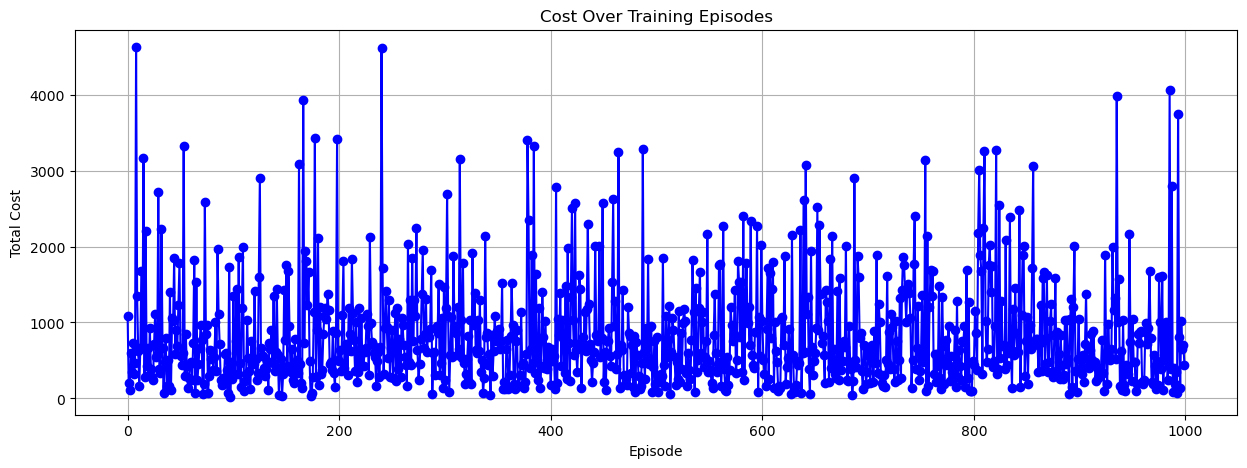

In [13]:
if __name__ == "__main__":
    # Define system matrices for a Spring-Mass-Damper (SMD) system.
    A = np.array([[1.0, 0.01],
              [-0.5, 0.98]])
    B = np.array([[0.0],
                  [0.01]])
    C = np.eye(2)
    noise_params = {
        'V': 0.01 * np.eye(2),
        'W': np.diag([0.04, 0.25])
    }
    
    # Instantiate the SMD system.
    system = SMDSystem(A, B, C, noise_params)
    
    # Set SCN parameters.
    num_neurons = 50
    state_dim = 2
    scn_params = {
        'dt': 1.0,
        'leak_rate': 0.1,
        'threshold': 1.0,
        # 'D_init' can be optionally specified; here we let it initialize randomly.
    }
    estimator = SpikingNeuralEstimator(num_neurons, state_dim, scn_params)
    
    # Instantiate the controller.
    control_dim = 1
    learning_rate = 1e-5
    sigma = 0.1  # exploration noise standard deviation
    controller = SpikingController(control_dim, num_neurons, learning_rate, sigma)
    
    # Set episode length.
    T = 100  # number of timesteps per episode
    
    # Run training.
    num_episodes = 1000
    costs, logs = train(num_episodes, system, estimator, controller, T)
    
    # Plot cost over episodes
    plt.figure(figsize=(15, 5))
    plt.plot(costs, marker='o', linestyle='-', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Total Cost')
    plt.title('Cost Over Training Episodes')
    plt.grid(True)
    plt.show()

How to improve the cost?